In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import glob 

In [2]:
files = glob.glob('/scratch/ct715/isca_data/held_suarez_delh_omega/*/*.nc')

ds = xr.open_mfdataset(files)

In [3]:
import sys
sys.path.append('/home/links/ct715/eddy_feedback/')

import functions.eddy_feedback as ef 
import functions.aos_functions as aos

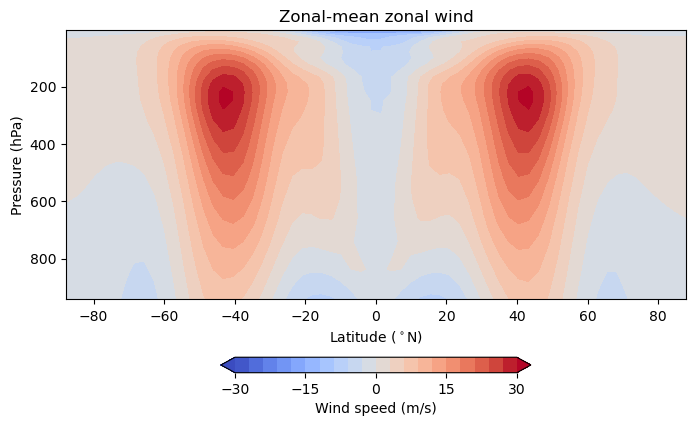

In [4]:
# This works without having to redefine ds in notebook!

ef.plot_ubar(ds)

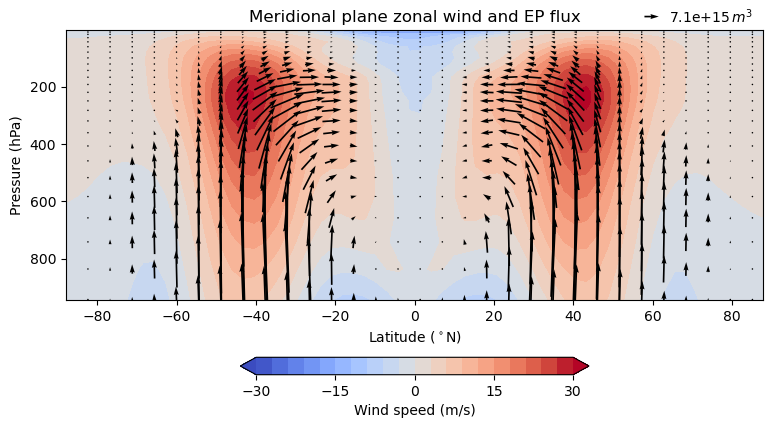

In [14]:
ef.plot_ubar_epflux(ds, skip_lat=2, skip_pres=1)

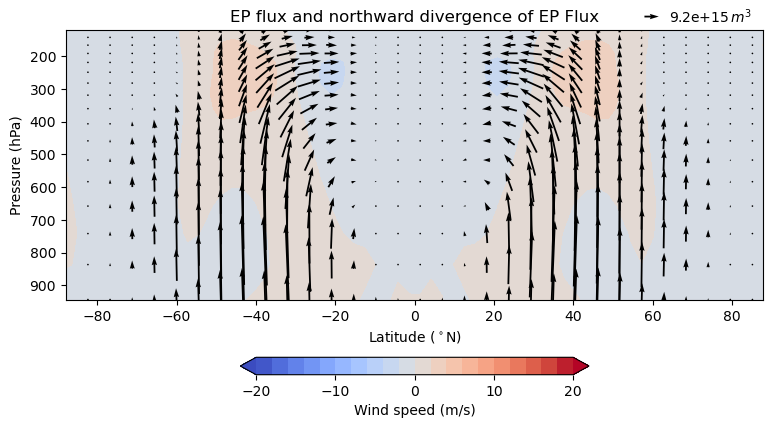

In [6]:
ef.plot_epfluxes_div(ds, skip_lat=2) 

# Contourf plot issues

In [7]:
# Now redefine ds for this notebook 

ds = ef.calculate_epfluxes_ubar(ds)
ds

<xarray.Dataset>
Dimensions:      (lon: 128, lonb: 129, lat: 64, latb: 65, time: 360, nv: 2,
                  phalf: 26, level: 25)
Coordinates:
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lonb         (lonb) float64 -1.406 1.406 4.219 7.031 ... 353.0 355.8 358.6
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * latb         (latb) float64 -90.0 -86.58 -83.76 -80.96 ... 83.76 86.58 90.0
  * time         (time) object 2000-01-01 12:00:00 ... 2000-12-30 12:00:00
  * nv           (nv) float64 1.0 2.0
  * phalf        (phalf) float64 0.0 6.165 12.71 22.59 ... 786.6 886.9 1e+03
  * level        (level) float64 2.268 9.244 17.42 28.92 ... 741.7 836.3 942.9
Data variables: (12/16)
    ps           (time, lat, lon) float32 dask.array<chunksize=(30, 64, 128), meta=np.ndarray>
    bk           (time, phalf) float32 dask.array<chunksize=(30, 26), meta=np.ndarray>
    pk           (time, phalf) float32 dask.array<chunksize=(30, 26), meta=np.ndarray>
    u            (time, level, lat, lon) float32 dask.array<chunksize=(30, 25, 64, 128), meta=np.ndarray>
    v            (time, level, lat, lon) float32 dask.array<chunksize=(30, 25, 64, 128), meta=np.ndarray>
    t            (time, level, lat, lon) float32 dask.array<chunksize=(30, 25, 64, 128), meta=np.ndarray>
    ...           ...
    time_bounds  (time, nv) timedelta64[ns] dask.array<chunksize=(30, 2), meta=np.ndarray>
    ubar         (level, lat) float32 dask.array<chunksize=(25, 64), meta=np.ndarray>
    ep1          (time, level, lat) float64 -1.809e-06 -9.443e-06 ... -0.482
    ep2          (time, level, lat) float64 6.842e-11 1.562e-10 ... -0.004506
    div1         (time, level, lat) float64 -2.665e-06 -5.916e-06 ... 0.8996
    div2         (time, level, lat) float64 -5.055e-07 -1.155e-06 ... 6.721 2.26
Attributes:
    filename:   /scratch/ct715/isca_work/experiment/held_suarez_delh_omega/ru...
    title:      FMS Model results
    grid_type:  regular
    grid_tile:  N/A

In [8]:
ds.ubar.values.min()

-20.71998

In [9]:
ds.ubar.values.max()

30.711105

In [10]:
max_value = ds.ubar.values.max()
min_value = ds.ubar.values.min()

value = (abs(max_value) + abs(min_value)) / 2
value = round(value, -1)
value

ticks = [-value, -value/2, 0, value/2, value]
ticks

[-30.0, -15.0, 0, 15.0, 30.0]

In [11]:
import numpy as np 

lvl = np.linspace(-value, value, 21)

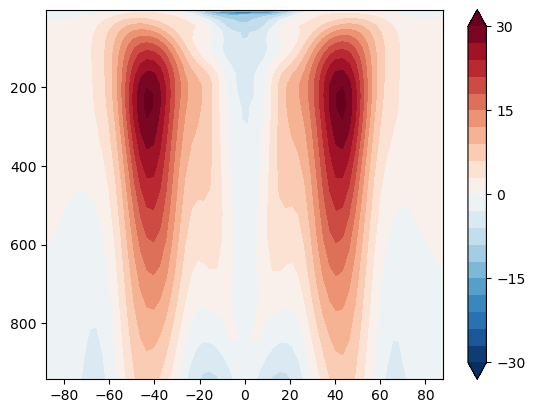

In [12]:
plt.figure()
plt.contourf(ds.lat.values, ds.level.values, ds.ubar, 
             levels=lvl, cmap='RdBu_r', extend='both')
plt.colorbar(extend='both',ticks=ticks)
plt.gca().invert_yaxis()
plt.show()

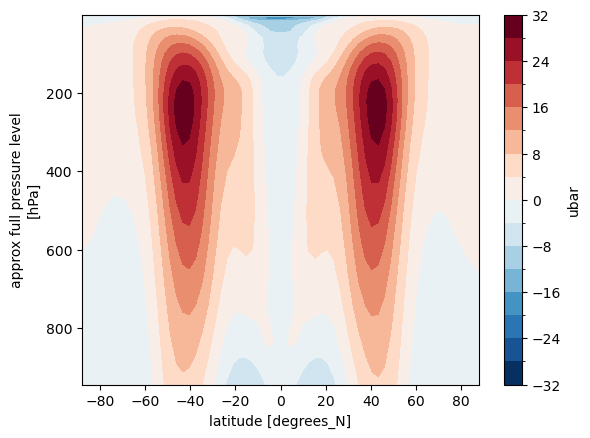

In [13]:
ds.ubar.plot.contourf(levels=20, yincrease=False, yscale='linear')

# Continuing on for now...